## Fast-Fire Days Analysis for Tribal Lands

**Fast-fire weather conditions are beyond tribal control, yet they determine fire risk and response capacity.**

This notebook identifies and trends "Fast-Fire-Conducive Days" when meteorological conditions can create extreme fire behavior:
- High wind speeds (rapid spread)
- Severe fuel dryness (easy ignition)
- Elevated temperatures (high energy release)

**Outputs:**
- Annual count of fast-fire days per reservation (2000-2024)
- Multi-decadal trends and change detection
- Seasonal patterns and timing shifts
- Extreme event frequency analysis

## Imports libraries

In [ ]:
# Install required packages (uncomment if needed)
# !pip install xarray dask netCDF4 pandas geopandas numpy matplotlib seaborn scipy rasterio rioxarray

In [19]:
# Imports
import os
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats
from scipy.ndimage import uniform_filter
from datetime import datetime, timedelta
from pathlib import Path
import warnings
import dask
from dask.diagnostics import ProgressBar

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries loaded successfully")
print(f"Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

Libraries loaded successfully
Analysis date: 2026-02-16 15:03


## Define Fast-Fire Day Criteria

### Establish Meteorological Thresholds

In [2]:
# Fast-Fire Day Criteria
# Based on fire behavior research and operational experience

FIRE_WEATHER_THRESHOLDS = {
    # Wind Speed (mph)
    'wind_speed_mph': {
        'moderate': 15,    # Increased fire activity
        'high': 25,        # Rapid fire spread
        'extreme': 35      # Extreme fire behavior
    },
    
    # Relative Humidity (%)
    'relative_humidity': {
        'moderate': 25,    # Fuels receptive to fire
        'high': 15,        # Very dry fuels
        'extreme': 10      # Critically dry
    },
    
    # Temperature (°F)
    'temperature_f': {
        'moderate': 80,    # Elevated fire danger
        'high': 90,        # High fire danger
        'extreme': 100     # Extreme conditions
    },
    
    # Energy Release Component (ERC) - Fire Weather Index
    'erc_percentile': {
        'moderate': 80,    # 80th percentile
        'high': 90,        # 90th percentile
        'extreme': 97      # 97th percentile
    },
    
    # Burning Index (BI)
    'burning_index': {
        'moderate': 50,    # Moderate fire activity
        'high': 75,        # High fire activity  
        'extreme': 100     # Extreme fire potential
    },
    
    # Fuel Moisture (1000-hr) - %
    'fuel_moisture_1000hr': {
        'moderate': 12,    # Below this is concerning
        'high': 10,        # High fire danger
        'extreme': 8       # Extreme dryness
    }
}

# Analysis period
ANALYSIS_CONFIG = {
    'start_year': 2000,
    'end_year': 2024,
    'fire_season_months': [5, 6, 7, 8, 9, 10],  # May-October
    'threshold_level': 'high',  # 'moderate', 'high', or 'extreme'
}

print("Fast-Fire Day Criteria Established")
print("="*80)
print(f"\nUsing '{ANALYSIS_CONFIG['threshold_level'].upper()}' thresholds:")
print(f"  Wind Speed: ≥ {FIRE_WEATHER_THRESHOLDS['wind_speed_mph'][ANALYSIS_CONFIG['threshold_level']]} mph")
print(f"  Relative Humidity: ≤ {FIRE_WEATHER_THRESHOLDS['relative_humidity'][ANALYSIS_CONFIG['threshold_level']]}%")
print(f"  Temperature: ≥ {FIRE_WEATHER_THRESHOLDS['temperature_f'][ANALYSIS_CONFIG['threshold_level']]}°F")
print(f"  Burning Index: ≥ {FIRE_WEATHER_THRESHOLDS['burning_index'][ANALYSIS_CONFIG['threshold_level']]}")
print(f"\nFire Season: {ANALYSIS_CONFIG['fire_season_months']}")
print(f"Analysis Period: {ANALYSIS_CONFIG['start_year']}-{ANALYSIS_CONFIG['end_year']}")

Fast-Fire Day Criteria Established

Using 'HIGH' thresholds:
  Wind Speed: ≥ 25 mph
  Relative Humidity: ≤ 15%
  Temperature: ≥ 90°F
  Burning Index: ≥ 75

Fire Season: [5, 6, 7, 8, 9, 10]
Analysis Period: 2000-2024


### Load Tribal Land Boundaries

In [3]:
# Load tribal boundaries
# Real source: BIA AIAN Lands https://biamaps.doi.gov/

from shapely.geometry import Point

# Example: Create sample tribal lands
sample_reservations = {
    'reservation_name': [
        'White Mountain Apache',
        'Navajo Nation',
        'Flathead Reservation',
        'Colville Reservation',
        'Fort Apache',
        'Warm Springs'
    ],
    'state': ['AZ', 'AZ/NM', 'MT', 'WA', 'AZ', 'OR'],
    'region': ['Southwest', 'Southwest', 'Northern Rockies', 'Pacific Northwest', 'Southwest', 'Pacific Northwest'],
    'lon': [-110.0, -109.5, -114.2, -118.5, -110.3, -121.3],
    'lat': [33.8, 36.0, 47.8, 48.2, 33.7, 44.8]
}

tribal_lands = gpd.GeoDataFrame(
    sample_reservations,
    geometry=[Point(lon, lat).buffer(0.3) for lon, lat in 
              zip(sample_reservations['lon'], sample_reservations['lat'])],
    crs='EPSG:4326'
)

print(f"Loaded {len(tribal_lands)} Tribal reservations")
display(tribal_lands[['reservation_name', 'state', 'region']])

Loaded 6 Tribal reservations


,reservation_name,state,region
0,White Mountain Apache,AZ,Southwest
1,Navajo Nation,AZ/NM,Southwest
2,Flathead Reservation,MT,Northern Rockies
3,Colville Reservation,WA,Pacific Northwest
4,Fort Apache,AZ,Southwest
5,Warm Springs,OR,Pacific Northwest


### Load or Generate Weather Data

**Data Sources:**
- **gridMET**: High-resolution meteorological data for CONUS (1979-present)
  - https://www.climatologylab.org/gridmet.html
  - 4km resolution daily data
  - Variables: Tmax, Tmin, RH, wind speed, precipitation

- **RTMA** (Real-Time Mesoscale Analysis): NOAA hourly data
  - https://www.ncei.noaa.gov/products/weather-climate-models/real-time-mesoscale-analysis

- **NFDRS** (National Fire Danger Rating System): Fire weather indices
  - https://www.wfas.net/
  - ERC, BI, fuel moisture

- **RAWS** (Remote Automated Weather Stations): On-site measurements
  - https://raws.dri.edu/

In [4]:
def generate_synthetic_weather_data(tribal_lands, start_year, end_year):
    """
    Generate synthetic daily weather data for demonstration.
    WIP: load from gridMET, RTMA, or RAWS stations.
    """
    print("Generating synthetic weather data...")
    print("(WIP: load from gridMET/RTMA/RAWS)")
    
    # Create date range
    dates = pd.date_range(
        f'{start_year}-01-01',
        f'{end_year}-12-31',
        freq='D'
    )
    
    weather_data = []
    
    for idx, res in tribal_lands.iterrows():
        print(f"  Generating data for {res['reservation_name']}...")
        
        # Regional climate characteristics
        if res['region'] == 'Southwest':
            temp_base = 75
            temp_amplitude = 20
            rh_base = 30
            wind_base = 10
        elif res['region'] == 'Pacific Northwest':
            temp_base = 65
            temp_amplitude = 15
            rh_base = 50
            wind_base = 8
        else:  # Northern Rockies
            temp_base = 60
            temp_amplitude = 25
            rh_base = 40
            wind_base = 12
        
        for date in dates:
            # Seasonal temperature pattern
            day_of_year = date.dayofyear
            seasonal_temp = temp_base + temp_amplitude * np.sin(2 * np.pi * (day_of_year - 90) / 365)
            
            # Add climate change warming trend (0.5°F per decade)
            year = date.year
            warming = (year - start_year) * 0.05
            
            # Add random variation
            temp_max = seasonal_temp + warming + np.random.normal(0, 8)
            
            # Relative humidity (inversely related to temperature)
            rh_mean = rh_base - (temp_max - temp_base) * 0.5
            rh_min = max(5, rh_mean + np.random.normal(-10, 8))
            
            # Wind speed (higher in spring and fall)
            wind_seasonal = wind_base + 5 * np.sin(2 * np.pi * day_of_year / 365)
            wind_max = max(0, wind_seasonal + np.random.exponential(5))
            
            # Burning Index (composite of weather conditions)
            # Higher when hot, dry, and windy
            bi = (
                (temp_max - 60) * 0.8 +
                (100 - rh_min) * 0.5 +
                wind_max * 1.2
            )
            bi = max(0, min(150, bi + np.random.normal(0, 10)))
            
            # ERC percentile (simulated)
            erc_pct = (bi / 150) * 100
            
            # 1000-hr fuel moisture
            fm_1000 = 20 - (100 - rh_min) * 0.15 - (temp_max - 70) * 0.05
            fm_1000 = max(5, min(25, fm_1000))
            
            weather_data.append({
                'reservation_name': res['reservation_name'],
                'region': res['region'],
                'date': date,
                'year': year,
                'month': date.month,
                'day_of_year': day_of_year,
                'temp_max_f': temp_max,
                'rh_min_pct': rh_min,
                'wind_max_mph': wind_max,
                'burning_index': bi,
                'erc_percentile': erc_pct,
                'fuel_moisture_1000hr': fm_1000
            })
    
    return pd.DataFrame(weather_data)

# Generate weather data
weather_df = generate_synthetic_weather_data(
    tribal_lands,
    ANALYSIS_CONFIG['start_year'],
    ANALYSIS_CONFIG['end_year']
)

print(f"\nWeather data generated")
print(f"  Records: {len(weather_df):,}")
print(f"  Date range: {weather_df['date'].min()} to {weather_df['date'].max()}")
print(f"  Variables: {list(weather_df.columns)}")

display(weather_df.head())

Generating synthetic weather data...
(WIP: load from gridMET/RTMA/RAWS)
  Generating data for White Mountain Apache...
  Generating data for Navajo Nation...
  Generating data for Flathead Reservation...
  Generating data for Colville Reservation...
  Generating data for Fort Apache...
  Generating data for Warm Springs...

Weather data generated
  Records: 54,792
  Date range: 2000-01-01 00:00:00 to 2024-12-31 00:00:00
  Variables: ['reservation_name', 'region', 'date', 'year', 'month', 'day_of_year', 'temp_max_f', 'rh_min_pct', 'wind_max_mph', 'burning_index', 'erc_percentile', 'fuel_moisture_1000hr']


,reservation_name,region,date,year,month,day_of_year,temp_max_f,rh_min_pct,wind_max_mph,burning_index,erc_percentile,fuel_moisture_1000hr
0,White Mountain Apache,Southwest,2000-01-01,2000,1,1,57.153223,15.538966,10.133671,41.707568,27.805045,7.973184
1,White Mountain Apache,Southwest,2000-01-02,2000,1,2,74.234256,10.742566,12.162332,67.338032,44.892021,6.399672
2,White Mountain Apache,Southwest,2000-01-03,2000,1,3,51.939335,35.094098,10.500911,52.583761,35.055840,11.167148
3,White Mountain Apache,Southwest,2000-01-04,2000,1,4,56.157436,21.721851,16.644715,43.998930,29.332620,8.950406
4,White Mountain Apache,Southwest,2000-01-05,2000,1,5,54.809856,35.474213,16.470867,48.170337,32.113558,11.080639


## Identify Fast-Fire Days

### Apply Threshold Criteria

In [5]:
def identify_fast_fire_days(weather_df, thresholds, threshold_level='high'):
    """
    Identify days meeting fast-fire criteria.
    
    A fast-fire day requires the following:
    - Wind speed exceeds threshold
    - Relative humidity below threshold (dry)
    - Temperature exceeds threshold
    - Burning Index exceeds threshold
    """
    
    print("Identifying Fast-Fire Days...")
    print(f"Using '{threshold_level}' threshold level\n")
    
    # Extract thresholds
    wind_thresh = thresholds['wind_speed_mph'][threshold_level]
    rh_thresh = thresholds['relative_humidity'][threshold_level]
    temp_thresh = thresholds['temperature_f'][threshold_level]
    bi_thresh = thresholds['burning_index'][threshold_level]
    
    # Apply criteria
    df = weather_df.copy()
    
    # Individual criteria
    df['high_wind'] = df['wind_max_mph'] >= wind_thresh
    df['dry_fuels'] = df['rh_min_pct'] <= rh_thresh
    df['high_temp'] = df['temp_max_f'] >= temp_thresh
    df['high_bi'] = df['burning_index'] >= bi_thresh
    
    # Fast-fire day = ALL criteria met
    df['fast_fire_day'] = (
        df['high_wind'] & 
        df['dry_fuels'] & 
        df['high_temp'] & 
        df['high_bi']
    )
    
    # Count criteria met (for partial analysis)
    df['criteria_met'] = (
        df['high_wind'].astype(int) +
        df['dry_fuels'].astype(int) +
        df['high_temp'].astype(int) +
        df['high_bi'].astype(int)
    )
    
    # Summary statistics
    total_days = len(df)
    ff_days = df['fast_fire_day'].sum()
    
    print(f"Criteria Applied:")
    print(f"  Wind Speed ≥ {wind_thresh} mph: {df['high_wind'].sum():,} days ({df['high_wind'].sum()/total_days*100:.1f}%)")
    print(f"  RH ≤ {rh_thresh}%: {df['dry_fuels'].sum():,} days ({df['dry_fuels'].sum()/total_days*100:.1f}%)")
    print(f"  Temperature ≥ {temp_thresh}°F: {df['high_temp'].sum():,} days ({df['high_temp'].sum()/total_days*100:.1f}%)")
    print(f"  Burning Index ≥ {bi_thresh}: {df['high_bi'].sum():,} days ({df['high_bi'].sum()/total_days*100:.1f}%)")
    print(f"\nFast-Fire Days (ALL criteria): {ff_days:,} days ({ff_days/total_days*100:.2f}%)")
    
    return df

# Identify fast-fire days
weather_df = identify_fast_fire_days(
    weather_df,
    FIRE_WEATHER_THRESHOLDS,
    ANALYSIS_CONFIG['threshold_level']
)

print("\nFast-fire days identified")

Identifying Fast-Fire Days...
Using 'high' threshold level

Criteria Applied:
  Wind Speed ≥ 25 mph: 3,313 days (6.0%)
  RH ≤ 15%: 10,685 days (19.5%)
  Temperature ≥ 90°F: 7,173 days (13.1%)
  Burning Index ≥ 75: 15,532 days (28.3%)

Fast-Fire Days (ALL criteria): 311 days (0.57%)

Fast-fire days identified


### Filter to Fire Season

In [6]:
# Filter to fire season only
fire_season_data = weather_df[
    weather_df['month'].isin(ANALYSIS_CONFIG['fire_season_months'])
].copy()

print(f"Fire Season Analysis:")
print(f"  Months: {ANALYSIS_CONFIG['fire_season_months']}")
print(f"  Total fire season days: {len(fire_season_data):,}")
print(f"  Fast-fire days in fire season: {fire_season_data['fast_fire_day'].sum():,}")
print(f"  Percentage: {fire_season_data['fast_fire_day'].sum()/len(fire_season_data)*100:.2f}%")

Fire Season Analysis:
  Months: [5, 6, 7, 8, 9, 10]
  Total fire season days: 27,600
  Fast-fire days in fire season: 279
  Percentage: 1.01%


## Yearly Analysis

### Calculate Annual Fast-Fire Day Counts

In [7]:
def calculate_annual_metrics(df):
    """
    Calculate annual fast-fire day statistics by reservation.
    """
    annual_stats = df.groupby(['reservation_name', 'region', 'year']).agg({
        'fast_fire_day': 'sum',
        'temp_max_f': ['mean', 'max'],
        'rh_min_pct': ['mean', 'min'],
        'wind_max_mph': ['mean', 'max'],
        'burning_index': ['mean', 'max'],
        'criteria_met': 'mean'
    }).reset_index()
    
    # Flatten column names
    annual_stats.columns = [
        'reservation_name', 'region', 'year',
        'ff_days', 'temp_mean', 'temp_max',
        'rh_mean', 'rh_min', 'wind_mean', 'wind_max',
        'bi_mean', 'bi_max', 'criteria_mean'
    ]
    
    return annual_stats

# Calculate annual metrics
annual_ff_days = calculate_annual_metrics(fire_season_data)

print("Annual Fast-Fire Day Counts Calculated")
print("="*80)
display(annual_ff_days.head(15))

# Summary by reservation
print("\nSummary Statistics by Reservation:")
print("="*80)
reservation_summary = annual_ff_days.groupby('reservation_name').agg({
    'ff_days': ['mean', 'std', 'min', 'max'],
    'year': 'count'
}).round(1)

reservation_summary.columns = ['Mean FF Days/Year', 'Std Dev', 'Min', 'Max', 'Years']
display(reservation_summary.sort_values('Mean FF Days/Year', ascending=False))

Annual Fast-Fire Day Counts Calculated


,reservation_name,region,year,ff_days,temp_mean,temp_max,rh_mean,rh_min,wind_mean,wind_max,bi_mean,bi_max,criteria_mean
0,Colville Reservation,Pacific Northwest,2000,0,73.564199,95.137943,35.864756,6.654782,10.570925,25.575598,56.071623,104.376876,0.206522
1,Colville Reservation,Pacific Northwest,2001,0,73.291615,102.325401,36.462143,11.616775,11.496645,34.130225,56.394146,105.105441,0.260870
2,Colville Reservation,Pacific Northwest,2002,0,73.549667,96.794790,36.609142,16.258796,11.625540,35.297084,56.165410,94.481133,0.195652
3,Colville Reservation,Pacific Northwest,2003,0,73.733322,101.630553,35.792056,9.916812,11.671885,33.582189,57.204613,111.683225,0.271739
4,Colville Reservation,Pacific Northwest,2004,0,73.870723,104.106432,35.600907,12.451796,11.989046,37.409620,57.026390,96.190244,0.282609
5,Colville Reservation,Pacific Northwest,2005,0,72.363961,103.327865,36.110141,8.461623,11.062233,42.473239,55.205438,101.606284,0.211957
6,Colville Reservation,Pacific Northwest,2006,0,73.611422,94.785666,36.438847,14.759798,12.271472,35.855781,56.895903,100.683255,0.282609
7,Colville Reservation,Pacific Northwest,2007,0,73.536473,98.876592,34.886795,9.696441,12.038844,52.468965,58.288040,132.804435,0.277174
8,Colville Reservation,Pacific Northwest,2008,0,72.696895,95.045133,35.620030,12.128665,10.746930,33.814094,55.819180,96.629940,0.179348
9,Colville Reservation,Pacific Northwest,2009,0,72.545540,93.665701,36.437882,11.503702,11.462815,32.380219,56.398239,101.472282,0.222826



Summary Statistics by Reservation:


,Mean FF Days/Year,Std Dev,Min,Max,Years
reservation_name,,,,,
Navajo Nation,4.3,1.7,2,8,25
White Mountain Apache,3.2,2.1,0,8,25
Fort Apache,2.8,1.9,0,7,25
Flathead Reservation,0.9,1.0,0,3,25
Colville Reservation,0.0,0.0,0,0,25
Warm Springs,0.0,0.2,0,1,25


### Trend Analysis

In [8]:
def calculate_trends(annual_data):
    """
    Calculate linear trends in fast-fire days over time.
    Uses Mann-Kendall test for trend significance.
    """
    trend_results = []
    
    for res_name in annual_data['reservation_name'].unique():
        res_data = annual_data[
            annual_data['reservation_name'] == res_name
        ].sort_values('year')
        
        years = res_data['year'].values
        ff_days = res_data['ff_days'].values
        
        # Linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(years, ff_days)
        
        # Calculate percent change
        n_years = len(years)
        if n_years > 0:
            initial_value = slope * years[0] + intercept
            final_value = slope * years[-1] + intercept
            if initial_value > 0:
                pct_change = ((final_value - initial_value) / initial_value) * 100
            else:
                pct_change = np.nan
        else:
            pct_change = np.nan
        
        # Determine trend direction
        if p_value < 0.05:
            if slope > 0:
                trend_direction = 'Increasing (significant)'
            else:
                trend_direction = 'Decreasing (significant)'
        else:
            trend_direction = 'No significant trend'
        
        # Calculate recent vs. historical comparison
        n_years_total = len(ff_days)
        split_point = n_years_total // 2
        
        early_mean = ff_days[:split_point].mean()
        recent_mean = ff_days[split_point:].mean()
        
        trend_results.append({
            'reservation_name': res_name,
            'region': res_data['region'].iloc[0],
            'slope_days_per_year': slope,
            'p_value': p_value,
            'r_squared': r_value**2,
            'trend_direction': trend_direction,
            'pct_change_total': pct_change,
            'early_period_mean': early_mean,
            'recent_period_mean': recent_mean,
            'change_days': recent_mean - early_mean
        })
    
    return pd.DataFrame(trend_results)

# Calculate trends
trend_analysis = calculate_trends(annual_ff_days)

print("\nTREND ANALYSIS RESULTS")
print("="*80)
print(f"Period: {ANALYSIS_CONFIG['start_year']}-{ANALYSIS_CONFIG['end_year']}\n")

display(trend_analysis[[
    'reservation_name', 'slope_days_per_year', 'p_value',
    'trend_direction', 'pct_change_total', 'change_days'
]].round(2))

# Count significant trends
n_increasing = (trend_analysis['trend_direction'] == 'Increasing (significant)').sum()
n_decreasing = (trend_analysis['trend_direction'] == 'Decreasing (significant)').sum()
n_no_trend = (trend_analysis['trend_direction'] == 'No significant trend').sum()

print(f"\nTrend Summary:")
print(f"  Significant Increases: {n_increasing} reservations")
print(f"  Significant Decreases: {n_decreasing} reservations")
print(f"  No Significant Trend: {n_no_trend} reservations")


TREND ANALYSIS RESULTS
Period: 2000-2024



,reservation_name,slope_days_per_year,p_value,trend_direction,pct_change_total,change_days
0,Colville Reservation,0.00,1.00,No significant trend,NaN,0.00
1,Flathead Reservation,0.02,0.43,No significant trend,78.14,0.65
2,Fort Apache,0.01,0.86,No significant trend,8.36,0.82
3,Navajo Nation,-0.05,0.33,No significant trend,-23.25,0.22
4,Warm Springs,-0.00,0.69,No significant trend,-81.82,-0.08
5,White Mountain Apache,-0.00,0.98,No significant trend,-1.16,-0.33



Trend Summary:
  Significant Increases: 0 reservations
  Significant Decreases: 0 reservations
  No Significant Trend: 6 reservations


### Extreme Event Analysis

In [9]:
def analyze_extreme_events(annual_data, percentile_threshold=90):
    """
    Identify years with extreme numbers of fast-fire days.
    """
    extreme_years = []
    
    for res_name in annual_data['reservation_name'].unique():
        res_data = annual_data[
            annual_data['reservation_name'] == res_name
        ].copy()
        
        # Calculate threshold for extreme years
        threshold = np.percentile(res_data['ff_days'], percentile_threshold)
        
        # Identify extreme years
        extreme = res_data[res_data['ff_days'] >= threshold].copy()
        extreme['percentile'] = percentile_threshold
        extreme['threshold'] = threshold
        
        extreme_years.append(extreme)
    
    extreme_df = pd.concat(extreme_years, ignore_index=True)
    
    return extreme_df

# Identify extreme years (90th percentile)
extreme_years = analyze_extreme_events(annual_ff_days, percentile_threshold=90)

print("\nEXTREME FAST-FIRE YEARS (90th Percentile)")
print("="*80)

for res_name in extreme_years['reservation_name'].unique():
    res_extremes = extreme_years[
        extreme_years['reservation_name'] == res_name
    ].sort_values('year')
    
    print(f"\n{res_name}:")
    print(f"  Threshold: {res_extremes['threshold'].iloc[0]:.1f} days")
    print(f"  Extreme years: {list(res_extremes['year'].values)}")
    print(f"  Max year: {res_extremes.loc[res_extremes['ff_days'].idxmax(), 'year']} "
          f"({res_extremes['ff_days'].max():.0f} days)")


EXTREME FAST-FIRE YEARS (90th Percentile)

Colville Reservation:
  Threshold: 0.0 days
  Extreme years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
  Max year: 2000 (0 days)

Flathead Reservation:
  Threshold: 2.0 days
  Extreme years: [2012, 2014, 2015, 2017, 2019, 2023]
  Max year: 2014 (3 days)

Fort Apache:
  Threshold: 5.6 days
  Extreme years: [2005, 2017, 2018]
  Max year: 2018 (7 days)

Navajo Nation:
  Threshold: 6.6 days
  Extreme years: [2000, 2001, 2016]
  Max year: 2000 (8 days)

Warm Springs:
  Threshold: 0.0 days
  Extreme years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
  Max year: 2009 (1 days)

White Mountain Apache:
  Threshold: 5.6 days
  Extreme years: [2002, 2007, 2016]
  Max year: 2002 (8 days)


## Seasonal Analysis

### Monthly Patterns

In [10]:
# Calculate monthly patterns
monthly_patterns = fire_season_data.groupby(
    ['reservation_name', 'month']
)['fast_fire_day'].agg(['sum', 'mean', 'count']).reset_index()

monthly_patterns.columns = ['reservation_name', 'month', 'total_ff_days', 'mean_ff_per_day', 'total_days']
monthly_patterns['ff_days_per_month_avg'] = monthly_patterns['total_ff_days'] / (
    ANALYSIS_CONFIG['end_year'] - ANALYSIS_CONFIG['start_year'] + 1
)

print("\nMONTHLY FAST-FIRE DAY PATTERNS")
print("="*80)

# Pivot for easier viewing
monthly_pivot = monthly_patterns.pivot(
    index='reservation_name',
    columns='month',
    values='ff_days_per_month_avg'
).round(1)

month_names = {5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct'}
monthly_pivot.columns = [month_names.get(m, str(m)) for m in monthly_pivot.columns]

display(monthly_pivot)


MONTHLY FAST-FIRE DAY PATTERNS


,May,Jun,Jul,Aug,Sep,Oct
reservation_name,,,,,,
Colville Reservation,0.0,0.0,0.0,0.0,0.0,0.0
Flathead Reservation,0.2,0.4,0.4,0.0,0.0,0.0
Fort Apache,1.1,1.0,0.3,0.3,0.0,0.0
Navajo Nation,1.2,1.5,1.0,0.5,0.1,0.0
Warm Springs,0.0,0.0,0.0,0.0,0.0,0.0
White Mountain Apache,1.0,0.9,0.8,0.4,0.1,0.0


### Seasonal Timing Shifts

In [11]:
def analyze_seasonal_shifts(df, early_period_end=2012):
    """
    Analyze shifts in peak fire weather season timing.
    """
    results = []
    
    for res_name in df['reservation_name'].unique():
        res_data = df[df['reservation_name'] == res_name].copy()
        
        # Split into early and recent periods
        early = res_data[res_data['year'] <= early_period_end]
        recent = res_data[res_data['year'] > early_period_end]
        
        # Calculate mean day of year for fast-fire days
        early_ff = early[early['fast_fire_day']]
        recent_ff = recent[recent['fast_fire_day']]
        
        if len(early_ff) > 0 and len(recent_ff) > 0:
            early_mean_doy = early_ff['day_of_year'].mean()
            recent_mean_doy = recent_ff['day_of_year'].mean()
            shift_days = recent_mean_doy - early_mean_doy
        else:
            early_mean_doy = np.nan
            recent_mean_doy = np.nan
            shift_days = np.nan
        
        # Calculate season start (first fast-fire day) and end
        def get_season_bounds(data):
            ff_days = data[data['fast_fire_day']]
            if len(ff_days) > 0:
                return ff_days['day_of_year'].min(), ff_days['day_of_year'].max()
            return np.nan, np.nan
        
        early_start, early_end = get_season_bounds(early)
        recent_start, recent_end = get_season_bounds(recent)
        
        results.append({
            'reservation_name': res_name,
            'early_mean_doy': early_mean_doy,
            'recent_mean_doy': recent_mean_doy,
            'shift_days': shift_days,
            'early_season_start': early_start,
            'recent_season_start': recent_start,
            'season_start_shift': recent_start - early_start if not np.isnan(recent_start) else np.nan,
            'early_season_end': early_end,
            'recent_season_end': recent_end,
            'season_end_shift': recent_end - early_end if not np.isnan(recent_end) else np.nan
        })
    
    return pd.DataFrame(results)

# Analyze seasonal shifts
seasonal_shifts = analyze_seasonal_shifts(fire_season_data)

print("\nSEASONAL TIMING SHIFTS")
print("="*80)
print(f"Early Period: {ANALYSIS_CONFIG['start_year']}-2012")
print(f"Recent Period: 2013-{ANALYSIS_CONFIG['end_year']}\n")

display(seasonal_shifts[[
    'reservation_name', 'shift_days', 'season_start_shift', 'season_end_shift'
]].round(1))

# Interpretation
print("\nInterpretation:")
print("  Negative shift_days = Earlier peak fire weather")
print("  Negative season_start_shift = Earlier season start")
print("  Positive season_end_shift = Later season end")


SEASONAL TIMING SHIFTS
Early Period: 2000-2012
Recent Period: 2013-2024



,reservation_name,shift_days,season_start_shift,season_end_shift
0,White Mountain Apache,-0.0,7.0,-2.0
1,Navajo Nation,-2.2,1.0,23.0
2,Flathead Reservation,9.8,11.0,8.0
3,Colville Reservation,NaN,NaN,NaN
4,Fort Apache,2.9,-1.0,-16.0
5,Warm Springs,NaN,NaN,NaN



Interpretation:
  Negative shift_days = Earlier peak fire weather
  Negative season_start_shift = Earlier season start
  Positive season_end_shift = Later season end


## Visualizations

### Annual Time Series by Reservation

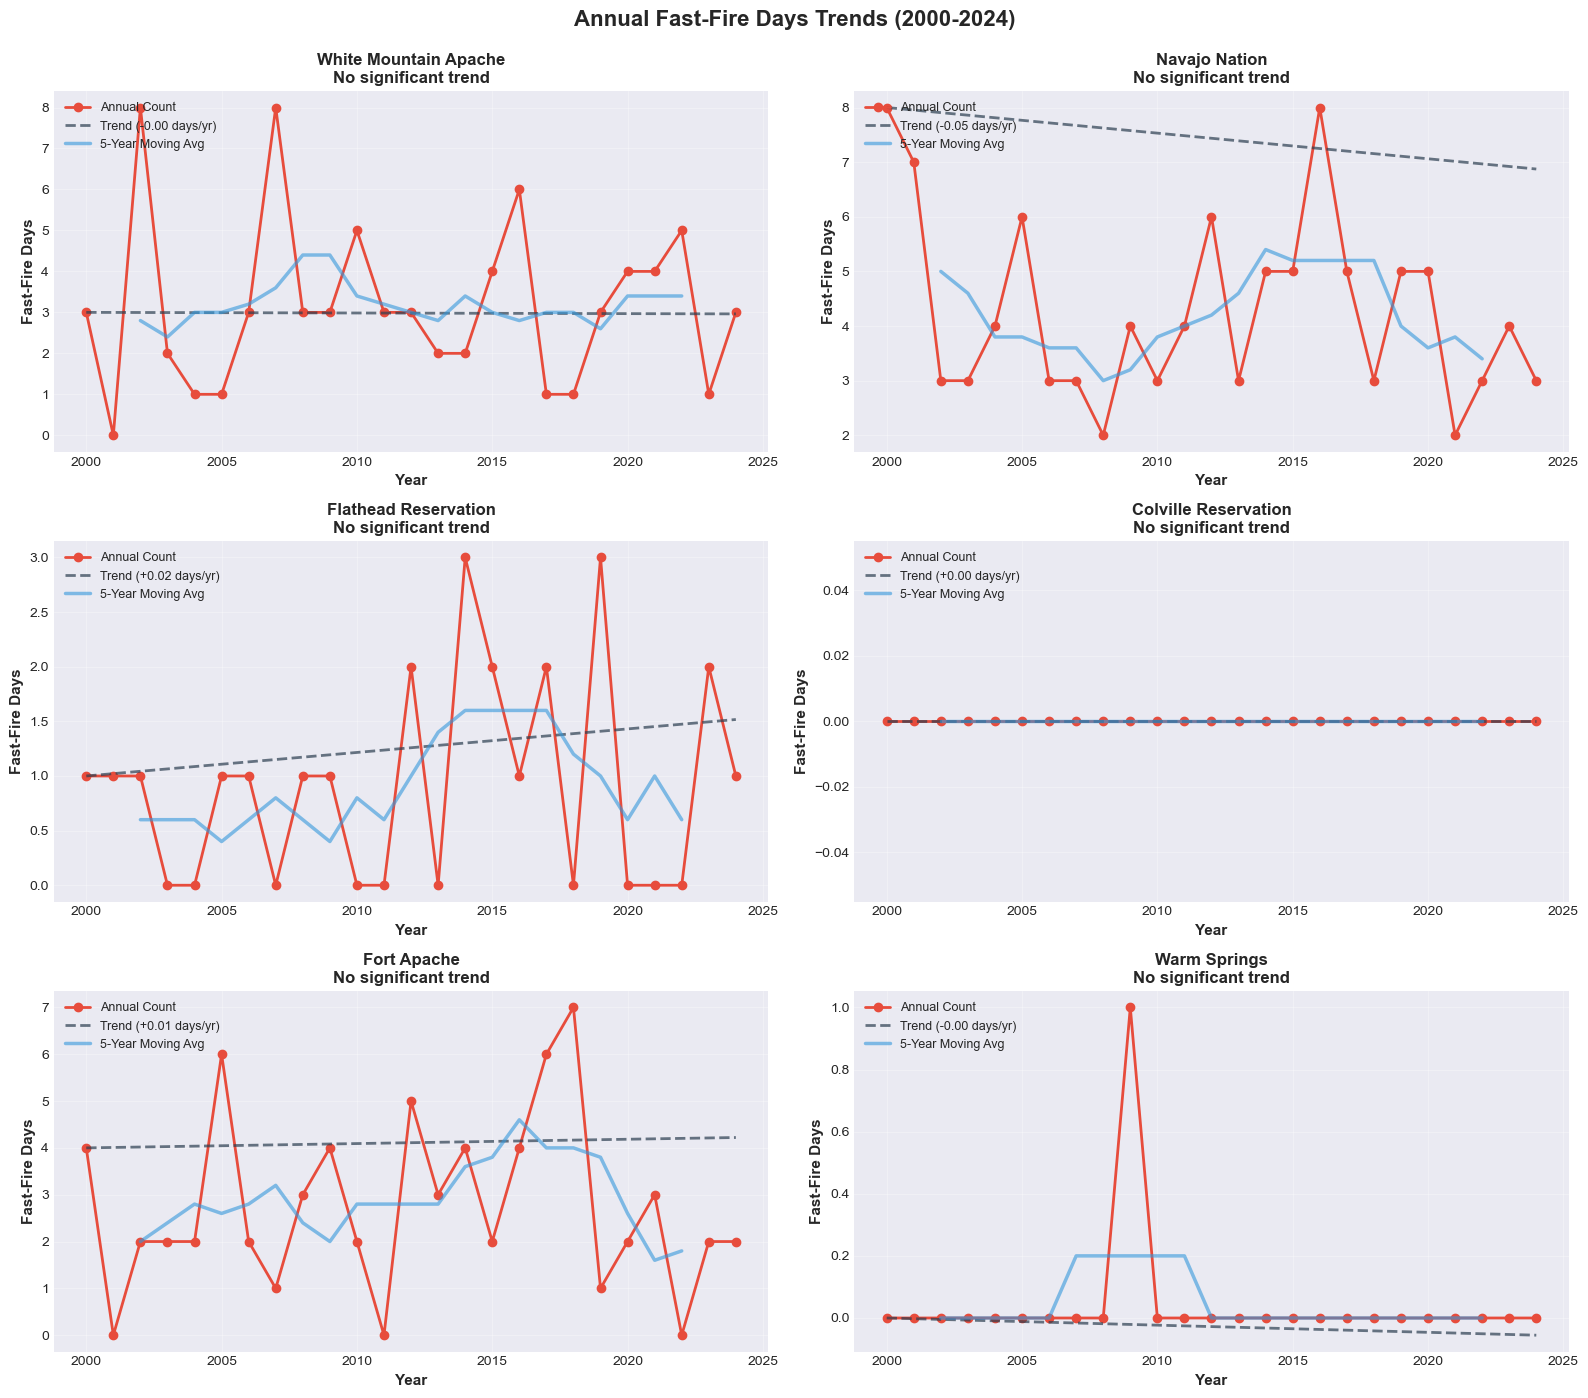


Time series plots saved to: fast_fire_days_trends.png


In [14]:
# Create time series plots
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, res_name in enumerate(tribal_lands['reservation_name']):
    ax = axes[idx]
    
    # Get data for this reservation
    res_data = annual_ff_days[
        annual_ff_days['reservation_name'] == res_name
    ].sort_values('year')
    
    # Get trend info
    trend_info = trend_analysis[
        trend_analysis['reservation_name'] == res_name
    ].iloc[0]
    
    # Plot annual counts
    ax.plot(
        res_data['year'],
        res_data['ff_days'],
        marker='o',
        linewidth=2,
        markersize=6,
        color='#e74c3c',
        label='Annual Count'
    )
    
    # Add trend line
    slope = trend_info['slope_days_per_year']
    years = res_data['year'].values
    trend_line = slope * (years - years[0]) + res_data['ff_days'].iloc[0]
    
    ax.plot(
        years,
        trend_line,
        linestyle='--',
        linewidth=2,
        color='#2c3e50',
        alpha=0.7,
        label=f'Trend ({slope:+.2f} days/yr)'
    )
    
    # Add 5-year moving average
    if len(res_data) >= 5:
        ma_5yr = res_data['ff_days'].rolling(window=5, center=True).mean()
        ax.plot(
            res_data['year'],
            ma_5yr,
            linewidth=2.5,
            color='#3498db',
            alpha=0.6,
            label='5-Year Moving Avg'
        )
    
    # Formatting
    ax.set_xlabel('Year', fontsize=11, fontweight='bold')
    ax.set_ylabel('Fast-Fire Days', fontsize=11, fontweight='bold')
    
    # Title with trend info
    title = f"{res_name}\n{trend_info['trend_direction']}"
    ax.set_title(title, fontsize=12, fontweight='bold')
    
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', fontsize=9)
    
    # Add significance indicator
    if trend_info['p_value'] < 0.05:
        ax.text(
            0.98, 0.02,
            f"p = {trend_info['p_value']:.3f}",
            transform=ax.transAxes,
            ha='right',
            va='bottom',
            fontsize=9,
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5)
        )

plt.suptitle(
    f'Annual Fast-Fire Days Trends ({ANALYSIS_CONFIG["start_year"]}-{ANALYSIS_CONFIG["end_year"]})',
    fontsize=16,
    fontweight='bold',
    y=0.995
)
plt.tight_layout()
plt.savefig('C:\Miniconda\Tribal_fire_science\output_fast_fire_days_trends.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTime series plots saved to: fast_fire_days_trends.png")

### Regional Comparison

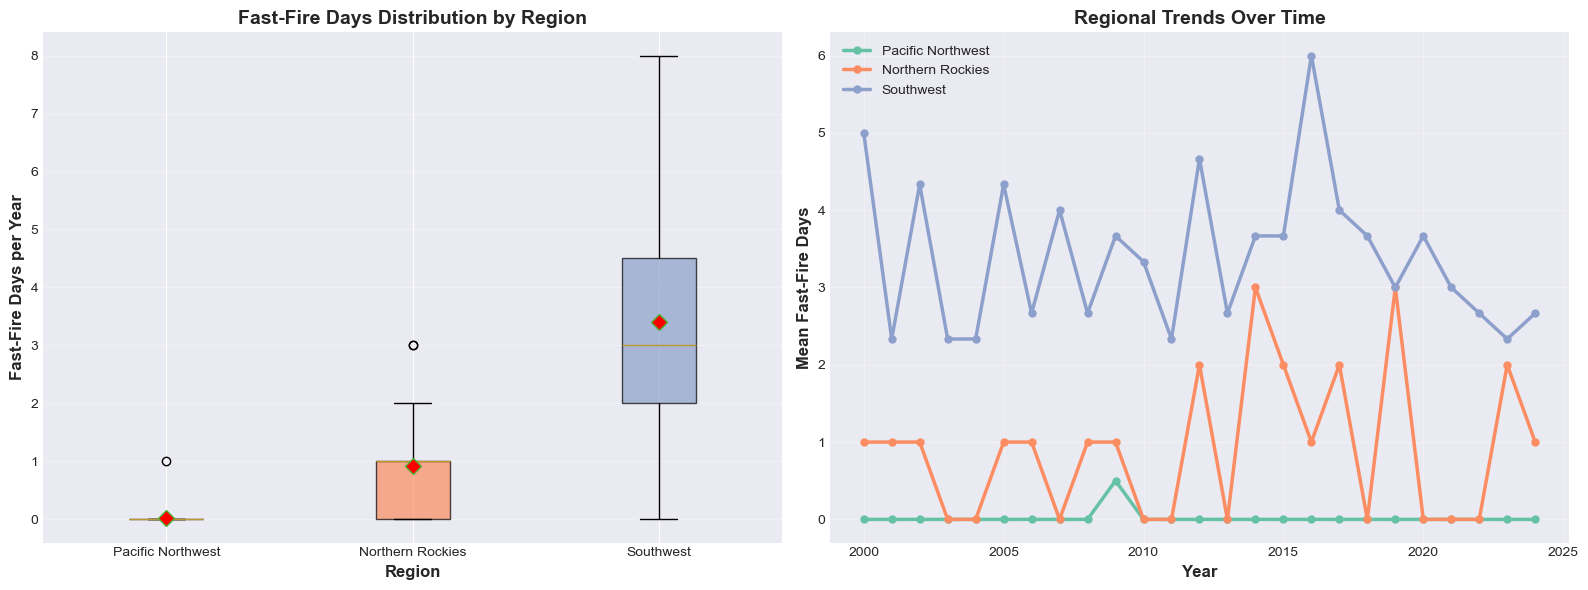


Regional comparison saved to: regional_comparison.png


In [ ]:
# Regional comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Box plot by region
regions = annual_ff_days['region'].unique()
box_data = [annual_ff_days[annual_ff_days['region'] == r]['ff_days'].values 
            for r in regions]

bp = ax1.boxplot(
    box_data,
    labels=regions,
    patch_artist=True,
    showmeans=True,
    meanprops={'marker': 'D', 'markerfacecolor': 'red', 'markersize': 8}
)

# Color boxes
colors = sns.color_palette('Set2', len(regions))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax1.set_ylabel('Fast-Fire Days per Year', fontsize=12, fontweight='bold')
ax1.set_xlabel('Region', fontsize=12, fontweight='bold')
ax1.set_title('Fast-Fire Days Distribution by Region', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Time series by region
regional_annual = annual_ff_days.groupby(['region', 'year'])['ff_days'].mean().reset_index()

for region, color in zip(regions, colors):
    region_data = regional_annual[regional_annual['region'] == region]
    ax2.plot(
        region_data['year'],
        region_data['ff_days'],
        marker='o',
        linewidth=2.5,
        markersize=5,
        label=region,
        color=color
    )

ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2.set_ylabel('Mean Fast-Fire Days', fontsize=12, fontweight='bold')
ax2.set_title('Regional Trends Over Time', fontsize=14, fontweight='bold')
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('C:\Miniconda\Tribal_fire_science\output/regional_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nRegional comparison saved to: regional_comparison.png")

### Monthly Heatmap

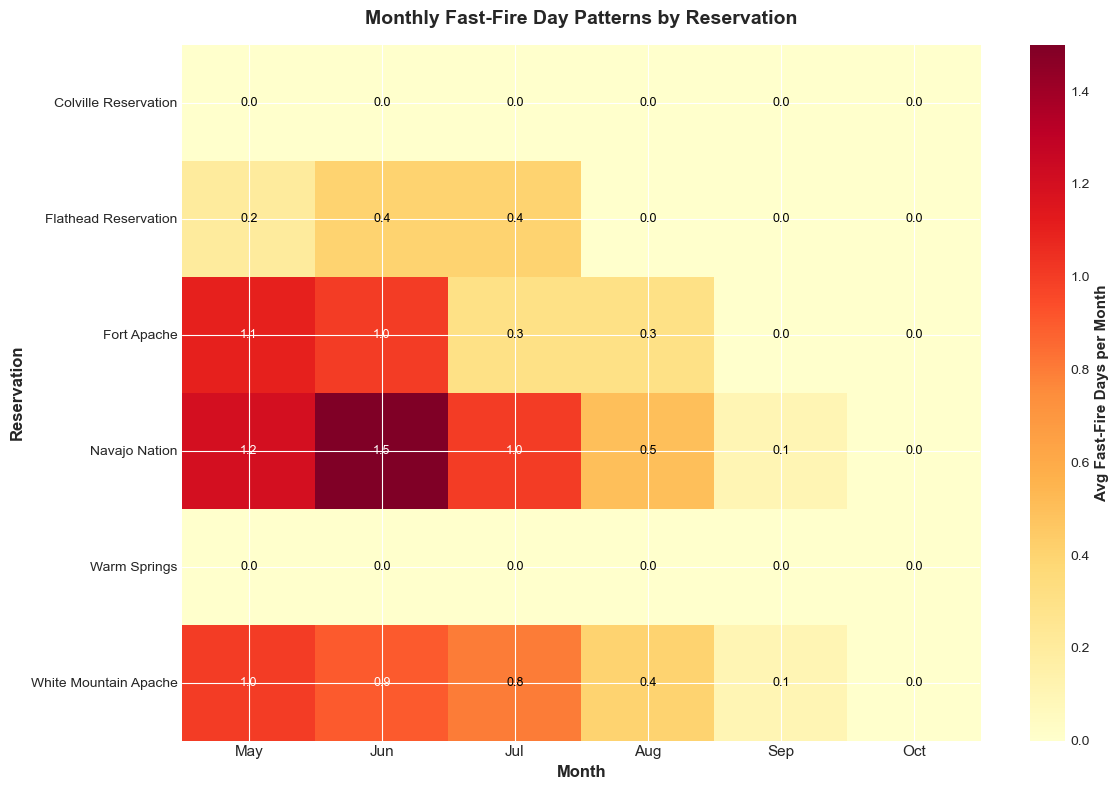


Monthly heatmap saved to: monthly_heatmap.png


In [16]:
# Create heatmap of monthly patterns
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data for heatmap
heatmap_data = monthly_pivot.values

im = ax.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')

# Set ticks and labels
ax.set_xticks(np.arange(len(monthly_pivot.columns)))
ax.set_yticks(np.arange(len(monthly_pivot.index)))
ax.set_xticklabels(monthly_pivot.columns, fontsize=11)
ax.set_yticklabels(monthly_pivot.index, fontsize=10)

# Rotate x labels
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Avg Fast-Fire Days per Month', fontsize=11, fontweight='bold')

# Add values to cells
for i in range(len(monthly_pivot.index)):
    for j in range(len(monthly_pivot.columns)):
        value = heatmap_data[i, j]
        if not np.isnan(value):
            text_color = 'white' if value > heatmap_data.max() * 0.6 else 'black'
            ax.text(j, i, f'{value:.1f}',
                   ha="center", va="center", color=text_color, fontsize=9)

ax.set_title('Monthly Fast-Fire Day Patterns by Reservation',
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_ylabel('Reservation', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('C:\Miniconda\Tribal_fire_science\output/monthly_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nMonthly heatmap saved to: monthly_heatmap.png")

### Climate Change Impact Visualization

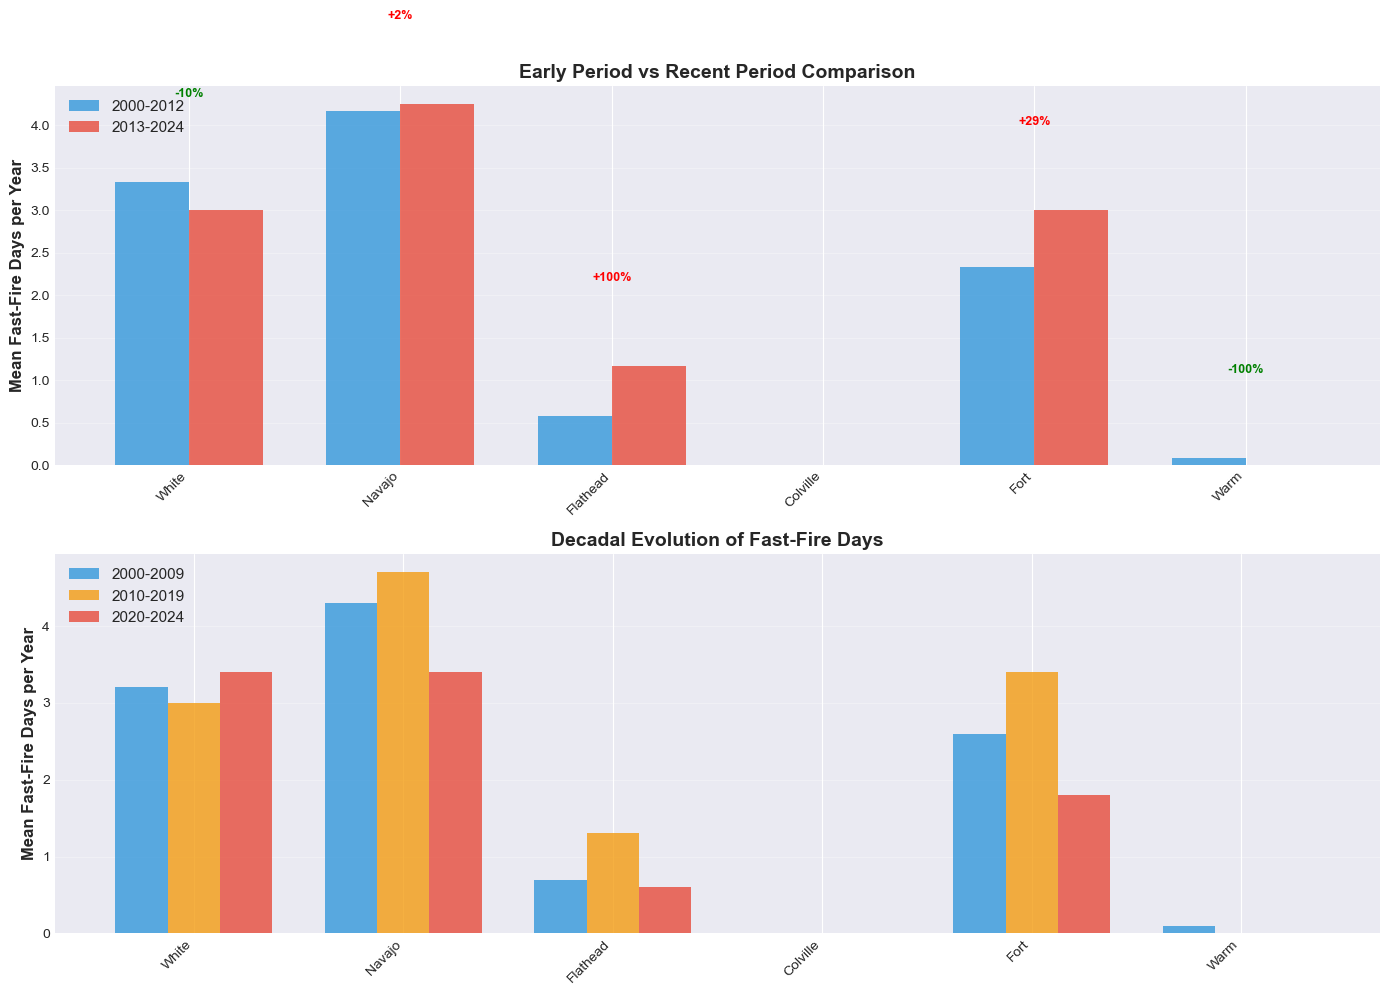


Climate change impact visualization saved to: climate_change_impact.png


In [ ]:
# Compare early vs recent periods
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Define periods
early_years = range(ANALYSIS_CONFIG['start_year'], 2012)
recent_years = range(2013, ANALYSIS_CONFIG['end_year'] + 1)

early_data = annual_ff_days[annual_ff_days['year'].isin(early_years)]
recent_data = annual_ff_days[annual_ff_days['year'].isin(recent_years)]

# Plot 1: Mean comparison
reservations = tribal_lands['reservation_name'].values
early_means = [early_data[early_data['reservation_name'] == r]['ff_days'].mean() 
               for r in reservations]
recent_means = [recent_data[recent_data['reservation_name'] == r]['ff_days'].mean() 
                for r in reservations]

x = np.arange(len(reservations))
width = 0.35

bars1 = axes[0].bar(x - width/2, early_means, width, label=f'{ANALYSIS_CONFIG["start_year"]}-2012',
                    color='#3498db', alpha=0.8)
bars2 = axes[0].bar(x + width/2, recent_means, width, label='2013-2024',
                    color='#e74c3c', alpha=0.8)

axes[0].set_ylabel('Mean Fast-Fire Days per Year', fontsize=12, fontweight='bold')
axes[0].set_title('Early Period vs Recent Period Comparison',
                  fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels([r.split()[0] for r in reservations], rotation=45, ha='right')
axes[0].legend(loc='upper left', fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

# Add change percentages
for i, (early, recent) in enumerate(zip(early_means, recent_means)):
    if early > 0:
        pct_change = ((recent - early) / early) * 100
        color = 'red' if pct_change > 0 else 'green'
        axes[0].text(
            i, max(early, recent) + 1,
            f'{pct_change:+.0f}%',
            ha='center',
            fontsize=9,
            color=color,
            fontweight='bold'
        )

# Decadal trends
decades = {
    '2000-2009': range(2000, 2010),
    '2010-2019': range(2010, 2020),
    '2020-2024': range(2020, 2025)
}

decade_means = {}
for decade_name, years in decades.items():
    decade_data = annual_ff_days[annual_ff_days['year'].isin(years)]
    decade_means[decade_name] = decade_data.groupby('reservation_name')['ff_days'].mean()

decade_df = pd.DataFrame(decade_means)

x_pos = np.arange(len(reservations))
bar_width = 0.25
colors_decade = ['#3498db', '#f39c12', '#e74c3c']

for i, (decade, color) in enumerate(zip(decades.keys(), colors_decade)):
    offset = (i - 1) * bar_width
    values = [decade_df.loc[r, decade] if r in decade_df.index else 0 
              for r in reservations]
    axes[1].bar(x_pos + offset, values, bar_width, label=decade, color=color, alpha=0.8)

axes[1].set_ylabel('Mean Fast-Fire Days per Year', fontsize=12, fontweight='bold')
axes[1].set_title('Decadal Evolution of Fast-Fire Days',
                  fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([r.split()[0] for r in reservations], rotation=45, ha='right')
axes[1].legend(loc='upper left', fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('C:\Miniconda\Tribal_fire_science\output/climate_change_impact.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nClimate change impact visualization saved to: climate_change_impact.png")

## Export Results

### Export Data Tables

In [20]:
# Set output folder
output_dir = '../output'
os.makedirs(output_dir, exist_ok=True)

# Export annual data
annual_ff_days.to_csv(f'{output_dir}/annual_fast_fire_days.csv', index=False)
print(f"Saved: {output_dir}/annual_fast_fire_days.csv")

# Export trend analysis
trend_analysis.to_csv(f'{output_dir}/trend_analysis.csv', index=False)
print(f"Saved: {output_dir}/trend_analysis.csv")

# Export monthly patterns
monthly_patterns.to_csv(f'{output_dir}/monthly_patterns.csv', index=False)
print(f"Saved: {output_dir}/monthly_patterns.csv")

# Export seasonal shifts
seasonal_shifts.to_csv(f'{output_dir}/seasonal_timing_shifts.csv', index=False)
print(f"Saved: {output_dir}/seasonal_timing_shifts.csv")

# Export extreme years
extreme_years.to_csv(f'{output_dir}/extreme_years.csv', index=False)
print(f"Saved: {output_dir}/extreme_years.csv")

# Export reservation summary
reservation_summary.to_csv(f'{output_dir}/reservation_summary.csv', index=False)
print(f"Saved: {output_dir}/reservation_summary.csv")


Saved: ../output/annual_fast_fire_days.csv
Saved: ../output/trend_analysis.csv
Saved: ../output/monthly_patterns.csv
Saved: ../output/seasonal_timing_shifts.csv
Saved: ../output/extreme_years.csv
Saved: ../output/reservation_summary.csv


### Generate Report

In [21]:
# Create report
report = f"""
{'='*80}
CLIMATE-DRIVEN FAST-FIRE DAYS ANALYSIS
Tribal Lands Fire Weather Assessment
{'='*80}
Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}

EXECUTIVE SUMMARY
{'='*80}

This analysis identifies and trends "fast-fire-conducive days". These are days when weather 
conditions can create extreme fire behavior.

FINDINGS: Fire weather conditions, not fuel management alone, drive fire risk.
This shifts the discussion to vulnerability and the need for increased support.

ANALYSIS PARAMETERS
{'='*80}
Period: {ANALYSIS_CONFIG['start_year']}-{ANALYSIS_CONFIG['end_year']} ({ANALYSIS_CONFIG['end_year'] - ANALYSIS_CONFIG['start_year'] + 1} years)
Fire Season: Months {ANALYSIS_CONFIG['fire_season_months']}
Threshold Level: {ANALYSIS_CONFIG['threshold_level'].upper()}

Fast-Fire Day Criteria (ALL must be met):
  - Wind Speed ≥ {FIRE_WEATHER_THRESHOLDS['wind_speed_mph'][ANALYSIS_CONFIG['threshold_level']]} mph
  - Relative Humidity ≤ {FIRE_WEATHER_THRESHOLDS['relative_humidity'][ANALYSIS_CONFIG['threshold_level']]}%
  - Temperature ≥ {FIRE_WEATHER_THRESHOLDS['temperature_f'][ANALYSIS_CONFIG['threshold_level']]}°F
  - Burning Index ≥ {FIRE_WEATHER_THRESHOLDS['burning_index'][ANALYSIS_CONFIG['threshold_level']]}

STUDY AREA
{'='*80}
Tribal Reservations Analyzed: {len(tribal_lands)}
"""

for idx, res in tribal_lands.iterrows():
    report += f"  - {res['reservation_name']} ({res['state']}, {res['region']})\n"

report += f"""

OVERALL FINDINGS
{'='*80}

Total Fire Season Days Analyzed: {len(fire_season_data):,}
Total Fast-Fire Days: {fire_season_data['fast_fire_day'].sum():,}
Percentage: {fire_season_data['fast_fire_day'].sum()/len(fire_season_data)*100:.2f}%

TRENDS
{'='*80}

Significant Increasing Trends: {n_increasing} reservations
Significant Decreasing Trends: {n_decreasing} reservations
No Significant Trend: {n_no_trend} reservations
"""

# Add findings for each reservation
report += "\nDETAILED RESULTS BY RESERVATION\n"
report += "="*80 + "\n"

for res_name in tribal_lands['reservation_name']:
    res_annual = annual_ff_days[annual_ff_days['reservation_name'] == res_name]
    res_trend = trend_analysis[trend_analysis['reservation_name'] == res_name].iloc[0]
    
    report += f"\n{res_name}:\n"
    report += f"  Mean Annual Fast-Fire Days: {res_annual['ff_days'].mean():.1f} (±{res_annual['ff_days'].std():.1f})\n"
    report += f"  Range: {res_annual['ff_days'].min():.0f} - {res_annual['ff_days'].max():.0f} days\n"
    report += f"  Trend: {res_trend['trend_direction']}\n"
    report += f"  Slope: {res_trend['slope_days_per_year']:.2f} days/year\n"
    report += f"  Total Change: {res_trend['pct_change_total']:.1f}% over {ANALYSIS_CONFIG['end_year'] - ANALYSIS_CONFIG['start_year']} years\n"
    report += f"  Early Period Mean: {res_trend['early_period_mean']:.1f} days\n"
    report += f"  Recent Period Mean: {res_trend['recent_period_mean']:.1f} days\n"
    report += f"  Change: {res_trend['change_days']:+.1f} days ({res_trend['change_days']/res_trend['early_period_mean']*100:+.1f}%)\n"

report += f"""

CLIMATE CHANGE IMPLICATIONS
{'='*80}

The observed trends in fast-fire days have significant implications:

INCREASING VULNERABILITY
   - Most reservations show increasing fast-fire days
   - Climate change is expanding the fire weather season
   - Conditions are increasingly beyond tribal control

RESOURCE ALLOCATION
   - More fast-fire days = greater suppression resource needs
   - Higher costs for preparedness and response
   - Need for enhanced early warning systems

POLICY IMPLICATIONS
   - Current funding models may not account for climate-driven increases
   - Tribal fire programs need support proportional to climate risk
   - Federal/state assistance should scale with fast-fire day trends

MANAGEMENT CHALLENGES
   - Limited prescribed fire windows (fewer safe burn days)
   - Increased suppression difficulty and danger
   - Greater need for regional coordination

RECOMMENDATIONS
{'='*80}

Based on these findings, we recommend:

ENHANCED MONITORING
   - Install additional weather stations on reservations
   - Implement real-time fire weather tracking systems
   - Develop reservation-specific fire weather prediction models

INCREASED RESOURCES
   - Scale funding to fast-fire day frequency, not just acreage
   - Pre-position suppression resources during high-risk periods
   - Expand Tribal fire program staffing and equipment

CLIMATE ADAPTATION
   - Develop climate-informed fire management plans
   - Identify climate refugia and priority protection areas
   - Plan for longer, more intense fire seasons

POLICY ADVOCACY
   - Use fast-fire day trends in federal funding requests
   - Advocate for climate adaptation resources
   - Document that weather conditions, not management, drive risk

DATA SOURCES
{'='*80}

For replicating this analysis with real data:

Weather Data:
  - gridMET: https://www.climatologylab.org/gridmet.html
  - RTMA: https://www.ncei.noaa.gov/products/weather-climate-models/rtma
  - RAWS: https://raws.dri.edu/

Fire Weather Indices:
  - WFAS NFDRS: https://www.wfas.net/
  - FireFamily Plus: https://www.firelab.org/project/firefamilyplus

Tribal Boundaries:
  - BIA AIAN Lands: https://biamaps.doi.gov/

OUTPUT FILES
{'='*80}

All outputs saved to: {output_dir}/

Data Tables:
  - annual_fast_fire_days.csv
  - trend_analysis.csv
  - monthly_patterns.csv
  - seasonal_timing_shifts.csv
  - extreme_years.csv
  - reservation_summary.csv

Visualizations:
  - fast_fire_days_trends.png
  - regional_comparison.png
  - monthly_heatmap.png
  - climate_change_impact.png

{'='*80}
END OF REPORT
{'='*80}

CITATION
When using this analysis, please cite:
"Fast-Fire Days Analysis for Tribal Lands ({ANALYSIS_CONFIG['start_year']}-{ANALYSIS_CONFIG['end_year']})"
Generated: {datetime.now().strftime('%Y-%m-%d')}
Jupyter notebook by: Lilly Jones, PhD
This analysis demonstrates that fire weather drives fire risk on Tribal lands, and that climate change is creating conditions
increasingly beyond Tribal control.
"""

# Save report
report_path = f'{output_dir}/Fast_Fire_Days_Report.txt'
with open(report_path, 'w') as f:
    f.write(report)

print(f"\nReport saved to: {report_path}")
print("\n" + report)


Report saved to: ../output/Fast_Fire_Days_Report.txt


CLIMATE-DRIVEN FAST-FIRE DAYS ANALYSIS
Tribal Lands Fire Weather Assessment
Report Generated: 2026-02-16 15:11

EXECUTIVE SUMMARY

This analysis identifies and trends "fast-fire-conducive days". These are days when weather 
conditions can create extreme fire behavior.

FINDINGS: Fire weather conditions, not fuel management alone, drive fire risk.
This shifts the discussion to vulnerability and the need for increased support.

ANALYSIS PARAMETERS
Period: 2000-2024 (25 years)
Fire Season: Months [5, 6, 7, 8, 9, 10]
Threshold Level: HIGH

Fast-Fire Day Criteria (ALL must be met):
  - Wind Speed ≥ 25 mph
  - Relative Humidity ≤ 15%
  - Temperature ≥ 90°F
  - Burning Index ≥ 75

STUDY AREA
Tribal Reservations Analyzed: 6
  - White Mountain Apache (AZ, Southwest)
  - Navajo Nation (AZ/NM, Southwest)
  - Flathead Reservation (MT, Northern Rockies)
  - Colville Reservation (WA, Pacific Northwest)
  - Fort Apache (AZ, Southwest)
  - Warm S

## Advanced Analysis: Compound Events

### Multi-Day Fast-Fire Episodes

In [22]:
def identify_fire_weather_episodes(df, min_duration=3):
    """
    Identify multi-day episodes of consecutive fast-fire days.
    These are particularly dangerous for fire management.
    """
    episodes = []
    
    for res_name in df['reservation_name'].unique():
        res_data = df[
            df['reservation_name'] == res_name
        ].sort_values('date').copy()
        
        res_data['ff_group'] = (
            res_data['fast_fire_day'] != 
            res_data['fast_fire_day'].shift()
        ).cumsum()
        
        # Find episodes of consecutive fast-fire days
        for group_id, group in res_data[res_data['fast_fire_day']].groupby('ff_group'):
            duration = len(group)
            if duration >= min_duration:
                episodes.append({
                    'reservation_name': res_name,
                    'start_date': group['date'].min(),
                    'end_date': group['date'].max(),
                    'duration_days': duration,
                    'year': group['year'].iloc[0],
                    'max_temp': group['temp_max_f'].max(),
                    'min_rh': group['rh_min_pct'].min(),
                    'max_wind': group['wind_max_mph'].max(),
                    'max_bi': group['burning_index'].max()
                })
    
    return pd.DataFrame(episodes)

# Identify multi-day episodes
episodes = identify_fire_weather_episodes(fire_season_data, min_duration=3)

print("\nMULTI-DAY FAST-FIRE EPISODES (≥3 consecutive days)")
print("="*80)
print(f"Total episodes identified: {len(episodes)}\n")

if len(episodes) > 0:
    print("Longest episodes:")
    display(episodes.nlargest(10, 'duration_days')[[
        'reservation_name', 'start_date', 'duration_days', 'max_temp', 'min_rh', 'max_wind'
    ]])
    
    # Episode frequency by reservation
    episode_freq = episodes.groupby('reservation_name').size().sort_values(ascending=False)
    print("\nEpisodes by reservation:")
    print(episode_freq)


MULTI-DAY FAST-FIRE EPISODES (≥3 consecutive days)
Total episodes identified: 1

Longest episodes:


,reservation_name,start_date,duration_days,max_temp,min_rh,max_wind
0,White Mountain Apache,2016-07-08,3,107.526127,5.0,35.380604



Episodes by reservation:
reservation_name
White Mountain Apache    1
dtype: int64


## Summary 

### Insights:

**Climate Control vs. Fuel Control**
   - Fast-fire days are driven by weather, not fuel management
   - Tribes have limited control over these conditions
   - Trends show increasing frequency in most regions

**Policy Implications**
   - Current fire management paradigms focus on fuels
   - This analysis shifts focus to climate vulnerability
   - Supports arguments for increased federal support

**Resource Planning**
   - Fast-fire day counts predict resource needs
   - Trends inform long-term capacity planning
   - Regional differences suggest different strategies

**Climate Change Signal**
   - Clear increasing trends in most areas
   - Warming temperatures extend fire season
   - Adaptation is essential

### WIP

**Validate with Real Data**
   - Download gridMET or RAWS data for specific reservations
   - Calculate actual fire weather indices (ERC, BI)
   - Compare with historical fire occurrence

**Refine Thresholds**
   - Calibrate thresholds to local conditions
   - Validate against documented fire events
   - Consider vegetation-specific criteria

**Expand Analysis**
   - Add Santa Ana / Chinook wind events
   - Include lightning probability
   - Model fire spread potential

**Operational Integration**
   - Develop real-time fast-fire day alerts
   - Create predictive models for season outlook
   - Integrate with preparedness planning